# Xgboost for holdout dataset

In [2]:
path_to_feature_dir = "safety/features/"
path_to_label_dir = "safety/labels/"

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from operator import itemgetter
import xgboost as xgb
import random
import time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from numpy import genfromtxt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc,recall_score,precision_score
import datetime as dt
import os
from tqdm import tqdm_notebook as tqdm
from scipy import stats
import gc
from sklearn.externals import joblib

/usr/local/envs/py3env/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
def signaltonoise(a, axis, ddof): 
    a = np.asanyarray(a) 
    m = a.mean(axis) 
    sd = a.std(axis = axis, ddof = ddof) 
    return np.where(sd == 0, 0, m / sd)

In [5]:
def read_multiple_csv(path):
    files = os.listdir(path)
    df = None
    pbar = tqdm(total=len(files))
    for f in files:
        ext = f.split(".")
        if len(ext)>0 and ext[-1] == "csv":
            #print(f)
            _ = pd.read_csv(os.path.join(path, f))
            if df is None:
                df = _
            else:
                df = df.append(_)
        pbar.update(1)
    del _
    gc.collect()
    return df

In [6]:
%%time
feature_df = read_multiple_csv(path_to_feature_dir)

CPU times: user 36.8 s, sys: 5.98 s, total: 42.8 s
Wall time: 42.8 s


In [7]:
label_df = read_multiple_csv(path_to_label_dir)
label_df.head()

,bookingID,label
0,111669149733,0
1,335007449205,1
2,171798691856,0
3,1520418422900,0
4,798863917116,0


In [9]:
# load model from file
model = joblib.load("models/xgboost_feature_engineered.model")

In [10]:
print(len(label_df))
# we can't keep both due to label contains both 0 and 1
label_df = label_df.drop_duplicates(subset=['bookingID'], keep=False)
print(len(label_df))

19982
19982


In [11]:
label_df = feature_df.groupby('bookingID',as_index=False)\
.agg({'Accuracy':'count'})\
.sort_values(by='Accuracy', ascending=False)\
.rename(columns={'Accuracy':'count'})\
.merge(label_df, on='bookingID', how='inner')

label_df.head()

,bookingID,count,label
0,438086664371,7561,1
1,1374389534819,4499,1
2,34359738469,4302,1
3,1108101562533,3925,1
4,747324309632,3674,1


In [12]:
len(label_df)

19982

In [13]:
# compute acceleration
feature_df = feature_df.fillna(0)
feature_df['acceleration'] = (feature_df['Speed']-feature_df['Speed'].shift())/\
(feature_df['second']-feature_df['second'].shift())
feature_df = feature_df.fillna(0)

In [14]:
len(feature_df)

16135561

In [15]:
%%time
# 1000 rows = 41.5 seconds
# 10000 rows = 5min 10s
# so 16,135,561 rows  = ~7 days
# the computing time is approx linear to number of rows  so no time to wait for the result
# feature_df.sample(10000).groupby('bookingID').describe()

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.39 µs


In [16]:
%%time
funcs = ['min','max','mean','median']
feat_df = feature_df.groupby('bookingID', as_index=False)\
.agg({'Speed':funcs, 'acceleration':funcs,'acceleration_x':funcs, 
      'acceleration_y':funcs, 'acceleration_z':funcs, 'second': 'max'})
feat_df.columns = feat_df.columns.map('|'.join).str.strip('|')

CPU times: user 10.5 s, sys: 781 ms, total: 11.3 s
Wall time: 11.3 s


In [17]:
%%time
# This function has less memory usage but slower due to 1 iteration handle one column only
for i in ['Bearing','acceleration_x', 'acceleration_y', 'acceleration_z','gyro_x', 'gyro_y', 'gyro_z']:
    feature_df['z_'+i] = np.abs(stats.zscore(feature_df[i]))
    feature_df[i+'_g_3'] = feature_df['z_'+i] > 3

    temp_df = feature_df.groupby('bookingID', as_index=False)\
    .agg({i+'_g_3':'sum'})

    feat_df = feat_df.merge(temp_df, on='bookingID', how='left')
    feature_df.drop(columns=[i+'_g_3','z_'+i])
    del temp_df
    gc.collect()

CPU times: user 18.9 s, sys: 22.1 s, total: 41 s
Wall time: 41 s


In [18]:
# count acceleration >= 2 and >= 3
feature_df['acceleration_ge_2'] = feature_df['acceleration'] >= 2
feature_df['acceleration_ge_3'] = feature_df['acceleration'] >= 3

temp_df = feature_df.groupby('bookingID', as_index=False)\
.agg({'acceleration_ge_2':'sum','acceleration_ge_3':'sum'})

feat_df = feat_df.merge(temp_df, on='bookingID', how='left')
feature_df.drop(columns=['acceleration_ge_2','acceleration_ge_3'])
del temp_df
gc.collect()

56

In [19]:
%%time
# compute signal to noise ratio
for i in ['Bearing','Speed','acceleration','acceleration_x', 'acceleration_y', 'acceleration_z','gyro_x', 'gyro_y', 'gyro_z']:
    temp_df = feature_df.groupby('bookingID').apply(lambda x: signaltonoise(x[i], axis=0, ddof=0))
    temp_df = temp_df.reset_index().rename(columns={0:i+'_snr'})
    temp_df = temp_df.replace([np.inf, -np.inf], -1)
    temp_df = temp_df.fillna(0)
    temp_df[i+'_snr'] = temp_df[i+'_snr'].astype('float64')
    feat_df = feat_df.merge(temp_df, on='bookingID', how='left')
    del temp_df
    gc.collect()

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/envs/py3env/lib/python3.5/site-packages/numpy/core/_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/usr/local/envs/py3env/lib/python3.5/site-packages/numpy/core/_methods.py:75: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/envs/py3env/lib/python3.5/site-packages/numpy/core/_methods.py:107: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)


CPU times: user 2min 18s, sys: 14.7 s, total: 2min 33s
Wall time: 2min 33s


In [20]:
feat_df = feat_df.replace([np.inf, -np.inf], -1)
feat_df = feat_df.fillna(0)

In [21]:
feat_df = feat_df.merge(label_df.drop(columns=['count']), on='bookingID', how='inner')

In [22]:
len(feat_df)

19982

In [23]:
feat_df.isnull().values.sum()

0

In [24]:
feat_df.sample(10)

,bookingID,second|max,acceleration|min,acceleration|max,acceleration|mean,acceleration|median,Speed|min,Speed|max,Speed|mean,Speed|median,...,Bearing_snr,Speed_snr,acceleration_snr,acceleration_x_snr,acceleration_y_snr,acceleration_z_snr,gyro_x_snr,gyro_y_snr,gyro_z_snr,label
12328,996432412719,1530.0,-4.076667,7.890000,0.014799,0.004113,0.000000,25.810000,8.134216,6.520000,...,1.245378,1.013098,0.043354,-0.045272,18.008776,4.176361,-0.013789,0.024338,-0.033890,1
2969,214748364964,419.0,-1.614380,2.056922,0.010153,0.006219,0.485750,21.341791,8.160629,7.274844,...,1.366600,1.489515,0.046805,0.113935,-13.228464,0.514310,-0.091478,-0.020205,-0.048220,1
14094,1151051235513,825.0,-18.790000,-1.000000,-1.000000,0.000833,0.000000,16.441021,5.946689,5.220456,...,1.480683,1.108407,0.000000,0.341084,14.685728,2.831484,0.025248,0.002778,0.010555,1
11754,953482739762,449.0,-20.012993,2.193271,-0.052753,0.000914,0.000000,20.801163,9.574979,12.850331,...,1.295047,1.184331,-0.053539,-0.660168,21.485855,7.750045,-0.040950,0.206538,0.185089,0
4306,335007449132,374.0,-5.693333,7.185665,0.054657,0.001289,-1.000000,25.044960,9.112271,7.893827,...,1.175360,1.196859,0.087033,0.081789,22.866424,-0.197371,-0.319559,-0.842363,0.253570,0
5789,446676598828,929.0,-1.000000,7.385097,-1.000000,0.002079,0.000000,29.811867,15.688319,17.630442,...,2.983218,1.850844,0.000000,0.246710,16.821999,1.322329,-0.019061,0.046319,0.051805,0
2481,180388626629,569.0,-2.748000,1.245555,-0.018010,0.005093,0.000000,15.620000,5.413743,3.780000,...,0.718361,1.002519,-0.067500,0.448081,15.617281,10.164228,-0.008123,0.059390,0.055667,0
9924,790273982615,869.0,-11.771532,-1.000000,-1.000000,0.008999,-1.000000,23.252136,6.774807,3.802588,...,1.192926,0.913046,0.000000,0.629657,-15.042109,-6.329486,-0.655068,-0.287266,0.043048,1
14184,1159641170053,719.0,-3.085662,-1.000000,-1.000000,0.004931,0.756276,16.984297,5.077238,3.981691,...,3.139649,1.276525,0.000000,-0.774281,-16.420177,0.773578,-0.037244,-0.067715,0.668308,0
2312,171798691954,1109.0,-6.629206,-1.000000,-1.000000,0.009560,-1.000000,26.590000,9.704500,9.095000,...,1.007468,1.199741,0.000000,-0.803599,17.924591,-1.714375,0.028680,0.037997,-0.032643,0


In [25]:
feat_df.describe()

,bookingID,second|max,acceleration|min,acceleration|max,acceleration|mean,acceleration|median,Speed|min,Speed|max,Speed|mean,Speed|median,...,Bearing_snr,Speed_snr,acceleration_snr,acceleration_x_snr,acceleration_y_snr,acceleration_z_snr,gyro_x_snr,gyro_y_snr,gyro_z_snr,label
count,1.998200e+04,1.998200e+04,19982.000000,19982.000000,19982.000000,19982.000000,19982.000000,19982.000000,19982.000000,19982.000000,...,19982.000000,19982.000000,19982.000000,19982.000000,19982.000000,19982.000000,1.998200e+04,1.998200e+04,1.998200e+04,19982.000000
mean,8.161654e+11,1.997500e+05,-5.183916,4.658037,-0.363164,0.004758,-0.229749,20.962369,8.427106,7.909898,...,2.350622,1.379657,0.009966,0.105295,7.649226,0.921966,-5.011695e+11,-1.229273e+11,1.310896e+11,0.249374
std,4.944728e+11,1.373755e+07,5.354948,5.745880,0.484721,0.004917,1.647574,5.315183,4.293325,5.707727,...,6.280023,1.117473,0.039491,1.403099,14.017292,3.807031,5.136108e+13,1.737672e+13,5.007862e+13,0.432662
min,0.000000e+00,1.190000e+02,-32.242094,-1.000000,-1.000000,-0.037522,-2.000000,-1.000000,-1.000000,-1.000000,...,0.000000,-5.709528,-0.706916,-21.930769,-100.073500,-45.471953,-6.140832e+15,-2.456333e+15,-3.521398e+15,0.000000
25%,3.865471e+11,5.540000e+02,-7.210923,0.499093,-1.000000,0.002298,-1.000000,17.256320,5.259188,3.535163,...,1.323344,0.987109,0.000000,-0.323965,-0.268547,-0.726496,-5.591672e-02,-5.977273e-02,-5.823254e-02,0.000000
50%,7.988639e+11,8.540000e+02,-3.186727,3.158137,-0.007141,0.005088,0.000000,21.058208,7.476763,6.549824,...,1.762051,1.189159,0.000000,0.070351,12.674634,0.707134,-7.199382e-03,-4.316469e-03,-5.419423e-03,0.000000
75%,1.245541e+12,1.217000e+03,-1.000000,7.062623,0.009032,0.007618,0.000000,24.902692,10.929455,11.300000,...,2.452378,1.457741,0.025466,0.472650,16.693681,2.474057,3.302861e-02,5.030578e-02,4.441973e-02,0.000000
max,1.709397e+12,1.495797e+09,-0.003981,32.350000,0.208250,0.025295,25.296043,148.018630,29.557195,30.468207,...,405.819974,33.092427,0.584441,38.572219,224.072356,199.294929,5.752457e+00,1.164161e+01,6.140832e+15,1.000000


In [26]:
feat_df = feat_df.sort_values(by='bookingID')

In [34]:
cols = ['acceleration_x|min', 'acceleration_x|max', 'acceleration_x|mean',
       'acceleration_x|median', 'Speed|min', 'Speed|max', 'Speed|mean',
       'Speed|median', 'second|max', 'acceleration_z|min',
       'acceleration_z|max', 'acceleration_z|mean', 'acceleration_z|median',
       'acceleration|min', 'acceleration|max', 'acceleration|mean',
       'acceleration|median', 'acceleration_y|min', 'acceleration_y|max',
       'acceleration_y|mean', 'acceleration_y|median', 'Bearing_g_3',
       'acceleration_x_g_3', 'acceleration_y_g_3', 'acceleration_z_g_3',
       'gyro_x_g_3', 'gyro_y_g_3', 'gyro_z_g_3', 'acceleration_ge_2',
       'acceleration_ge_3', 'Bearing_snr', 'Speed_snr', 'acceleration_snr',
       'acceleration_x_snr', 'acceleration_y_snr', 'acceleration_z_snr',
       'gyro_x_snr', 'gyro_y_snr', 'gyro_z_snr']

In [36]:
X = feat_df[cols]

In [37]:
y_pred = model.predict(xgb.DMatrix(X), ntree_limit=model.best_iteration+1)
y_pred = (y_pred > 0.5).astype(int)

# Check for AUC

In [38]:
# take only label 0 and 1
y = feat_df['label'].values

In [39]:
# Compute micro-average ROC curve and ROC area
fpr, tpr, _ = roc_curve(y, y_pred)
roc_auc = auc(fpr, tpr)

In [40]:
print(roc_auc)

0.5916765914035047


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


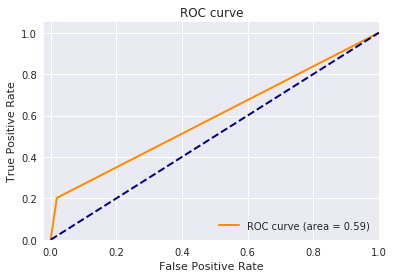

In [42]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()